In [132]:
import pickle
with open("/content/drive/MyDrive/WaterBalance_new/notebook/ds_array_4.pkl", "rb") as f:
    ds_array_4 = pickle.load(f)

with open("/content/drive/MyDrive/WaterBalance_new/notebook/Ea_pyet.pkl", "rb") as f:
    Ea_pyet = pickle.load(f)

Ea_pyet
ds_array_4

<xarray.Dataset>
Dimensions:             (time: 1, y: 13, x: 20)
Coordinates:
  * x                   (x) float32 -109.3 -109.2 -109.1 ... -107.5 -107.4
  * y                   (y) float32 44.55 44.45 44.35 ... 43.55 43.45 43.35
  * time                (time) datetime64[ns] 2022-01-31
    spatial_ref         int64 0
Data variables:
    precipitation       (time, y, x) float32 nan nan nan nan ... nan nan nan nan
    runoff              (time, y, x) float64 nan nan nan nan ... nan nan nan nan
    underground_runoff  (time, y, x) float64 nan nan nan nan ... nan nan nan nan
    soilmoisture        (time, y, x) float32 nan nan nan nan ... nan nan nan nan
    sub_soilmoisture    (time, y, x) float32 nan nan nan nan ... nan nan nan nan
    shapefile           (y, x) float64 nan nan nan nan nan ... nan nan nan nan
Attributes:
    history:          Created on 2022-02-05 07:15
    input_data_hash:  27d78e1ad0241438dcb7b796dee6d7c1393f1b4522680997748376e...

In [91]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
pip install netCDF4 geopandas wxee geemap rasterio rioxarray

In [100]:
import os
import sys
import pandas as pd
import numpy as np
import netCDF4 as nc
import xarray as xr
import geopandas as gpd
import ee
import wxee
import geemap
import rasterio
import rioxarray
import itertools

sys.path.append('/content/drive/MyDrive/WaterBalance_new/')

from qdwb.soil_content.soil_content import *
from qdwb.soil_content.constant import *

In [94]:
ee.Authenticate()
wxee.Initialize()


To authorize access needed by Earth Engine, open the following URL in a web browser and follow the instructions. If the web browser does not start automatically, please manually browse the URL below.

    https://code.earthengine.google.com/client-auth?scopes=https%3A//www.googleapis.com/auth/earthengine%20https%3A//www.googleapis.com/auth/devstorage.full_control&request_id=wl2I_IHoOhYQ85RwXEJNkZ0SuTBIitsoVe02CTooFX4&tc=bWeKjPOzep5Uz91ZtZ3h2X5sRYeHO4trzveaC5_g8qA&cc=YShpG8CNpkdAs0KujK9I3OJc7qj7_U7X9DnhKSzV0zQ

The authorization workflow will generate a code, which you should paste in the box below.
Enter verification code: 4/1AbUR2VMAH5EE7TIleWLomCrYKW8Ksy3B7swFrre04nfGj2mqU7v7boHYrNk

Successfully saved authorization token.


In [95]:
Map = geemap.Map()
Map.add_basemap('HYBRID')

# USA
LAT_MIN = 43.30
LAT_MAX = 44.60
LON_MIN = -109.40
LON_MAX = -107.40

# Soil depths [in cm] where we have data.
olm_depths = [0, 10, 30, 60, 100, 200]

# Names of bands associated with reference depths.
olm_bands = ["b" + str(sd) for sd in olm_depths]

def get_soil_prop(param):
    """
    This function returns soil properties image
    param (str): must be one of:
        "sand"     - Sand fraction
        "clay"     - Clay fraction
        "orgc"     - Organic Carbon fraction
    """
    if param == "sand":  # Sand fraction [%w]
        snippet = "OpenLandMap/SOL/SOL_SAND-WFRACTION_USDA-3A1A1A_M/v02"
        # Define the scale factor in accordance with the dataset description.
        scale_factor = 1 * 0.01

    elif param == "clay":  # Clay fraction [%w]
        snippet = "OpenLandMap/SOL/SOL_CLAY-WFRACTION_USDA-3A1A1A_M/v02"
        # Define the scale factor in accordance with the dataset description.
        scale_factor = 1 * 0.01

    elif param == "orgc":  # Organic Carbon fraction [g/kg]
        snippet = "OpenLandMap/SOL/SOL_ORGANIC-CARBON_USDA-6A1C_M/v02"
        # Define the scale factor in accordance with the dataset description.
        scale_factor = 5 * 0.001  # to get kg/kg
    else:
        return print("error")

    # Apply the scale factor to the ee.Image.
    dataset = ee.Image(snippet).multiply(scale_factor)

    return dataset


# Image associated with the sand content.
sand = get_soil_prop("sand")

# Image associated with the clay content.
clay = get_soil_prop("clay")

# Image associated with the organic carbon content.
orgc = get_soil_prop("orgc")


# shape = ee.Geometry.Rectangle([LON_MAX,LAT_MIN,LON_MIN,LAT_MAX])
# sand_w = sand.clip(shape)
# sand_w = sand_w.set("system:time_start", ee.Date("2022-01-31"))
# arr = sand_w.wx.to_xarray(scale=250, crs='EPSG:4326')
# arr

In [109]:

lat_of_points = list(Ea_pyet.y.values.flatten())
lon_of_points = list(Ea_pyet.x.values.flatten())

grid = [(float(i), float(j)) for i, j in itertools.product(lon_of_points, lat_of_points)]
x_values = [t[0] for t in grid]
y_values = [t[1] for t in grid]
# for i in Ea_pyet.x.values:
#     for j in Ea_pyet.y.values:
#       i = float(i)
#       j = float(j)
#       blank_list.append((i,j))

In [114]:
_
# Define the location of interest with a point.
lon = LON_MAX
lat = LAT_MAX
poi = ee.Geometry.Point(lon, lat)

# A nominal scale in meters of the projection to work in [in meters].
scale = 9000

def local_profile(dataset, x, y, buffer):
    # Get properties at the location of interest and transfer to client-side.
    poi = ee.Geometry.Point(x, y)
    prop = dataset.sample(poi, buffer).select(olm_bands).getInfo()

    # Selection of the features/properties of interest.
    profile = prop["features"][0]["properties"]

    # Re-shaping of the dict.
    profile = {key: round(val, 3) for key, val in profile.items()}

    return profile

# Conversion of organic carbon content into organic matter content.
orgm = orgc.multiply(1.724)

# Organic matter content profile.

list_2_org = np.array([local_profile(
    dataset = orgm,
    x = i,
    y = j,
    buffer = scale
)
for i, j in zip(x_values, y_values)])

# points = list(map(lambda xi, yi: ee.Geometry.Point(xi, yi), x_values, y_values))


# list_2_org = [local_profile(dataset = orgm, x = k[0], y = k[1], buffer = scale) for k in grid]

list_2_org = list_2_org.reshape(1,13,20)

# for k in grid:
#   profile_orgm = local_profile(dataset = orgm, x = k[0], y = k[1], buffer = scale)
#   list_2_org.append(profile_orgm)



# list_2 = local_profile(dataset = orgm, x = -109.35, y = 44.55, buffer = scale)
# list_2


array([[[{'b0': 0.06, 'b10': 0.043, 'b100': 0.009, 'b200': 0.009, 'b30': 0.017, 'b60': 0.017},
         {'b0': 0.052, 'b10': 0.034, 'b100': 0.009, 'b200': 0.009, 'b30': 0.017, 'b60': 0.017},
         {'b0': 0.034, 'b10': 0.034, 'b100': 0.009, 'b200': 0.009, 'b30': 0.017, 'b60': 0.009},
         {'b0': 0.103, 'b10': 0.06, 'b100': 0.009, 'b200': 0.009, 'b30': 0.026, 'b60': 0.017},
         {'b0': 0.086, 'b10': 0.069, 'b100': 0.017, 'b200': 0.017, 'b30': 0.034, 'b60': 0.017},
         {'b0': 0.103, 'b10': 0.069, 'b100': 0.017, 'b200': 0.017, 'b30': 0.043, 'b60': 0.026},
         {'b0': 0.086, 'b10': 0.06, 'b100': 0.009, 'b200': 0.009, 'b30': 0.026, 'b60': 0.017},
         {'b0': 0.129, 'b10': 0.095, 'b100': 0.017, 'b200': 0.017, 'b30': 0.034, 'b60': 0.026},
         {'b0': 0.112, 'b10': 0.069, 'b100': 0.009, 'b200': 0.009, 'b30': 0.017, 'b60': 0.009},
         {'b0': 0.078, 'b10': 0.052, 'b100': 0.009, 'b200': 0.009, 'b30': 0.034, 'b60': 0.017},
         {'b0': 0.026, 'b10': 0.026, 'b100'

In [127]:
# Initialization of two constant images for wilting point and field capacity.
wilting_point = ee.Image(0)
field_capacity = ee.Image(0)

# Calculation for each standard depth using a loop.
for key in olm_bands:
    # Getting sand, clay and organic matter at the appropriate depth.
    si = sand.select(key)
    ci = clay.select(key)
    oi = orgm.select(key)

    # Calculation of the wilting point.
    # The theta_1500t parameter is needed for the given depth.
    theta_1500ti = (
        ee.Image(0)
        .expression(
            "-0.024 * S + 0.487 * C + 0.006 * OM + 0.005 * (S * OM)\
        - 0.013 * (C * OM) + 0.068 * (S * C) + 0.031",
            {
                "S": si,
                "C": ci,
                "OM": oi,
            },
        )
        .rename("T1500ti")
    )

    # Final expression for the wilting point.
    wpi = theta_1500ti.expression(
        "(T1500ti + ( 0.14 * T1500ti - 0.002)) * 100", {"T1500ti": theta_1500ti}
    ).rename("wpi")

    # Add as a new band of the global wilting point ee.Image.
    # Do not forget to cast the type with float().
    wilting_point = wilting_point.addBands(wpi.rename(key).float())

    # Same process for the calculation of the field capacity.
    # The parameter theta_33t is needed for the given depth.
    theta_33ti = (
        ee.Image(0)
        .expression(
            "-0.251 * S + 0.195 * C + 0.011 * OM +\
        0.006 * (S * OM) - 0.027 * (C * OM)+\
        0.452 * (S * C) + 0.299",
            {
                "S": si,
                "C": ci,
                "OM": oi,
            },
        )
        .rename("T33ti")
    )

    # Final expression for the field capacity of the soil.
    fci = theta_33ti.expression(
        "(T33ti + (1.283 * T33ti * T33ti - 0.374 * T33ti - 0.015)) * 100",
        {"T33ti": theta_33ti.select("T33ti")},
    )

    # Add a new band of the global field capacity ee.Image.
    field_capacity = field_capacity.addBands(fci.rename(key).float())

In [128]:

list_2_wp = [local_profile(
    dataset = wilting_point,
    x = i,
    y = j,
    buffer = scale
)
for i, j in zip(x_values, y_values)]




# list_2_wp = [] 
# for k in blank_list:
#   x = k[0]
#   y = k[1]
#   profile_orgm = local_profile(dataset = wilting_point, x = x, y = y, buffer = scale)
#   list_2_wp.append(profile_orgm)

list_2_wp

[{'b0': 12.731,
  'b10': 13.323,
  'b100': 13.232,
  'b200': 12.61,
  'b30': 13.886,
  'b60': 13.856},
 {'b0': 11.505,
  'b10': 12.1,
  'b100': 11.998,
  'b200': 11.984,
  'b30': 13.256,
  'b60': 13.225},
 {'b0': 13.287,
  'b10': 14.483,
  'b100': 13.839,
  'b200': 13.815,
  'b30': 15.666,
  'b60': 15.059},
 {'b0': 10.328,
  'b10': 10.874,
  'b100': 11.341,
  'b200': 10.725,
  'b30': 11.429,
  'b60': 11.991},
 {'b0': 10.944,
  'b10': 11.511,
  'b100': 10.763,
  'b200': 10.763,
  'b30': 10.839,
  'b60': 10.801},
 {'b0': 9.701,
  'b10': 10.276,
  'b100': 9.494,
  'b200': 9.494,
  'b30': 10.216,
  'b60': 10.147},
 {'b0': 10.909,
  'b10': 10.874,
  'b100': 10.107,
  'b200': 10.123,
  'b30': 10.801,
  'b60': 10.763},
 {'b0': 11.564,
  'b10': 11.524,
  'b100': 10.763,
  'b200': 11.363,
  'b30': 11.442,
  'b60': 11.399},
 {'b0': 10.957,
  'b10': 10.931,
  'b100': 10.747,
  'b200': 10.747,
  'b30': 10.839,
  'b60': 10.785},
 {'b0': 12.661,
  'b10': 13.85,
  'b100': 13.181,
  'b200': 13.169,
  

In [129]:
list_2_fc = [local_profile(
    dataset = field_capacity,
    x = i,
    y = j,
    buffer = scale
)
for i, j in zip(x_values, y_values)]






# list_2_fc = [] 
# # for k in range(len(blank_list)):
# for k in blank_list:
#   x = k[0]
#   y = k[1]
#   profile_orgm = local_profile(dataset = field_capacity, x = x, y = y, buffer = scale)
#   list_2_fc.append(profile_orgm)

list_2_fc

[{'b0': 22.588,
  'b10': 23.306,
  'b100': 22.202,
  'b200': 21.235,
  'b30': 23.596,
  'b60': 23.171},
 {'b0': 20.882,
  'b10': 21.608,
  'b100': 20.474,
  'b200': 20.26,
  'b30': 22.432,
  'b60': 22.003},
 {'b0': 22.863,
  'b10': 24.14,
  'b100': 22.956,
  'b200': 22.545,
  'b30': 25.401,
  'b60': 24.652},
 {'b0': 19.655,
  'b10': 19.9,
  'b100': 19.064,
  'b200': 18.294,
  'b30': 20.17,
  'b60': 20.27},
 {'b0': 20.412,
  'b10': 20.893,
  'b100': 18.741,
  'b200': 18.741,
  'b30': 19.645,
  'b60': 19.192},
 {'b0': 18.679,
  'b10': 19.17,
  'b100': 16.766,
  'b200': 16.766,
  'b30': 18.676,
  'b60': 17.976},
 {'b0': 20.156,
  'b10': 19.9,
  'b100': 17.524,
  'b200': 17.744,
  'b30': 19.192,
  'b60': 18.741},
 {'b0': 21.177,
  'b10': 20.914,
  'b100': 18.741,
  'b200': 19.29,
  'b30': 20.191,
  'b60': 19.734},
 {'b0': 20.433,
  'b10': 20.391,
  'b100': 18.523,
  'b200': 18.523,
  'b30': 19.645,
  'b60': 18.971},
 {'b0': 21.7,
  'b10': 22.975,
  'b100': 21.371,
  'b200': 21.164,
  'b30'

In [154]:
wp_list = list(map(lambda dict: dict['b0'], list_2_wp))
fc_list = list(map(lambda dict: dict['b0'], list_2_fc))


In [155]:
with open("/content/drive/MyDrive/WaterBalance_new/notebook/Ea_pyet.pkl", "rb") as f:
    Ea_pyet = pickle.load(f)

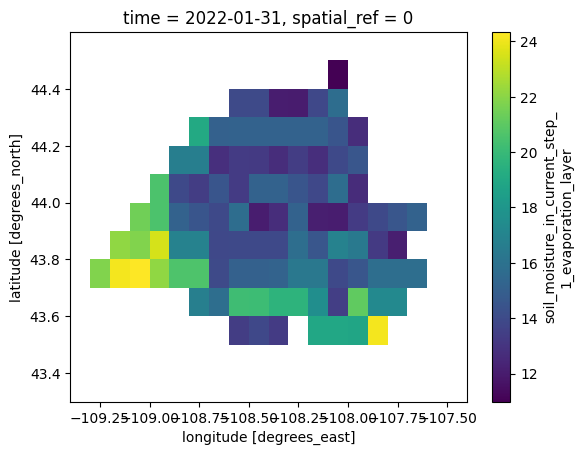

In [156]:

# soil_water_content_of_evaporation_layer_at_previous_step = xds_repr_match__soilmoisture
# infiltration = underground_runoff
# evaporation = E_a_pyet
# field_capacity_soil_water_content_of_evaporation_layer = 60
# permanent_wilting_point_soil_water_content_of_evaporation_layer = 15
# coverd = True
# infiltration_to_transpiration_layer = 2
# infiltration_to_transition_layer = 0

# temp_1 = (soil_water_content_of_evaporation_layer_at_previous_step.ssm.values) + (infiltration.underground_runoff.values) - (evaporation.Hargreaves.values) - (infiltration_to_transpiration_layer)

Ea_pyet = list(Ea_pyet.Hargreaves.values.flatten())
underground_runoff = list(ds_array_4.underground_runoff.values.flatten())
soil = list(ds_array_4.soilmoisture.values.flatten())

soil_moisture_in_current_step_1 = np.array([SoilContent.evaporation_layer(
    soil_water_content_of_evaporation_layer_at_previous_step = float(z),
    infiltration = float(j),
    evaporation = float(i),
    field_capacity_soil_water_content_of_evaporation_layer = fc,
    permanent_wilting_point_soil_water_content_of_evaporation_layer = wp,
    coverd = True,
    infiltration_to_transpiration_layer = 0
)[0]
for i, j, z, fc, wp in zip(Ea_pyet, underground_runoff, soil, fc_list, wp_list)])

evaporation_adjusted_1 = np.array([SoilContent.evaporation_layer(
    soil_water_content_of_evaporation_layer_at_previous_step = float(z),
    infiltration = float(j),
    evaporation = float(i),
    field_capacity_soil_water_content_of_evaporation_layer = fc,
    permanent_wilting_point_soil_water_content_of_evaporation_layer = wp,
    coverd = True,
    infiltration_to_transpiration_layer = 0
)[1]
for i, j, z, fc, wp in zip(Ea_pyet, underground_runoff, soil, fc_list, wp_list)])

infiltration_to_transpiration_layer_adjusted_1 = np.array([SoilContent.evaporation_layer(
    soil_water_content_of_evaporation_layer_at_previous_step = float(z),
    infiltration = float(j),
    evaporation = float(i),
    field_capacity_soil_water_content_of_evaporation_layer = fc,
    permanent_wilting_point_soil_water_content_of_evaporation_layer = wp,
    coverd = True,
    infiltration_to_transpiration_layer = 0
)[2]
for i, j, z, fc, wp in zip(Ea_pyet, underground_runoff, soil, fc_list, wp_list)])

infiltration_to_transition_layer_adjusted_1 = np.array([SoilContent.evaporation_layer(
    soil_water_content_of_evaporation_layer_at_previous_step = float(z),
    infiltration = float(j),
    evaporation = float(i),
    field_capacity_soil_water_content_of_evaporation_layer = fc,
    permanent_wilting_point_soil_water_content_of_evaporation_layer = wp,
    coverd = True,
    infiltration_to_transpiration_layer = 0
)[3]
for i, j, z, fc, wp in zip(Ea_pyet, underground_runoff, soil, fc_list, wp_list)])

soil_moisture_in_current_step_1 = soil_moisture_in_current_step_1.reshape(1,13,20)
evaporation_adjusted_1 = evaporation_adjusted_1.reshape(1,13,20)
infiltration_to_transpiration_layer_adjusted_1 = infiltration_to_transpiration_layer_adjusted_1.reshape(1,13,20)
infiltration_to_transition_layer_adjusted_1 = infiltration_to_transition_layer_adjusted_1.reshape(1,13,20)


ds_array_5 = ds_array_4.assign(soil_moisture_in_current_step_1_evaporation_layer=(['time', 'y', 'x'], soil_moisture_in_current_step_1))
ds_array_6 = ds_array_5.assign(evaporation_adjusted_1=(['time', 'y', 'x'], evaporation_adjusted_1))
ds_array_7 = ds_array_6.assign(infiltration_to_transpiration_layer_adjusted_1=(['time', 'y', 'x'], infiltration_to_transpiration_layer_adjusted_1))
ds_array_8 = ds_array_7.assign(infiltration_to_transition_layer_adjusted_1=(['time', 'y', 'x'], infiltration_to_transition_layer_adjusted_1))

# ds_array.soil_moisture_in_current_step_evaporation_layer.plot()
ds_array_8.soil_moisture_in_current_step_1_evaporation_layer.plot()


In [146]:
Map = geemap.Map()
Map.add_basemap('HYBRID')

shape = ee.FeatureCollection('projects/ee-mohammadnejadmehdi77/assets/sample_usa')

dem = ee.Image("USGS/SRTMGL1_003").clip(shape)

Map.centerObject(shape, 9)
Map.addLayer(ee_object = dem, vis_params = {'min':-10, 'max':6500}, name = 'dem')
Map

Map(center=[43.88531410627492, -108.32657408653418], controls=(WidgetControl(options=['position', 'transparent…

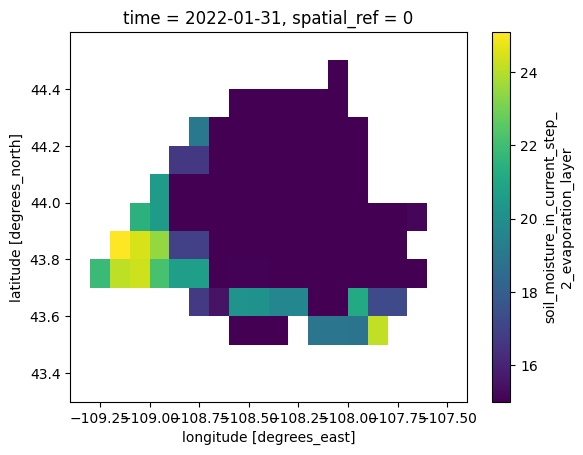

In [122]:
soil_moisture_in_current_step_2 = np.array([SoilContent.evaporation_layer(
    soil_water_content_of_evaporation_layer_at_previous_step = float(z),
    infiltration = float(j),
    evaporation = float(i),
    field_capacity_soil_water_content_of_evaporation_layer = 27,
    permanent_wilting_point_soil_water_content_of_evaporation_layer = 15,
    coverd = True,
    infiltration_to_transpiration_layer = 0
)[0]
for i, j, z in zip(Ea_pyet, underground_runoff, soil)])

soil_moisture_in_current_step_2 = soil_moisture_in_current_step_2.reshape(1,13,20)
ds_array_5 = ds_array_4.assign(soil_moisture_in_current_step_2_evaporation_layer=(['time', 'y', 'x'], soil_moisture_in_current_step_2))
ds_array_5.soil_moisture_in_current_step_2_evaporation_layer.plot()

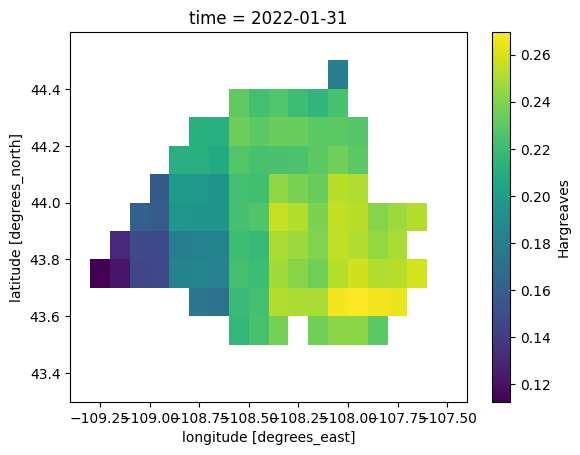

In [149]:
with open("/content/drive/MyDrive/WaterBalance_new/notebook/Ea_pyet.pkl", "rb") as f:
    Ea_pyet = pickle.load(f)

Ea_pyet.Hargreaves.plot()